# Gradient Descent / SGD Task 2.1

In [79]:
import numpy as np

# Seed para tener reproducibilidad
np.random.seed(42)

## 1. Generacion de Datos

### a. 1,000 datos basados en la función $2x^3 - 3x^2 + 5x + 3$
Aquí podemos simplemente utilizar Numpy para generar 1000 valores aleatorios entre -5 y 5 para obtener nuestro x, luego evaluando cada uno de ellos en el polinomio para obtener y.

In [80]:
import numpy as np

# 1000 puntos entre -5 y 5
x = np.random.rand(1000, 1) * 10 - 5

# Evaluar puntos para calcular y
y = 2 * (x**3) - 3 * (x**2) + 5 * x + 3

### b. Agregar ruido normal a y para que los puntos no sean perfectos
Aquí antes de empezar, vamos a calcular la desviación estandar en y para obtener una escala adecuada de ruido. Buscamos que el ruido tenga un 15% de la desviación estandar de y.

In [81]:
# Calcular 15% de la desviación estandar
noise_level = y.std() * 0.15

print(f"{noise_level}")

16.837724141361825


Ahora podemos ver que nuestros valores seguirán una distribución normal con una desviación promedio de +/- 16.83. Podemos proceder a calcular el ruido y agregárselo a y.

In [82]:
# 1000 valores aleatorios de ruido
noise = np.random.randn(1000, 1) * noise_level

# Agregar ruido a Y
y = y + noise

### c. Normalización
En el lab mencionaban que no se podía utilizar SKLearn para la lógica de los algoritmos, sin embargo asumo que si se puede utilizar para tasks triviales cómo normalizar los datos utilizando un Scaler.

In [83]:
from sklearn.preprocessing import StandardScaler

# Normalizar X
scaler_x = StandardScaler()
x_norm = scaler_x.fit_transform(x)

# Normalizar Y
scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

## 2. Implementación de Algoritmos
### Nota: Me perdí un poco con las instrucciones, mencionaba utilizar derivadas manuales pero a la vez operaciones vectoriales. Supongo que era calcular las derivadas "a manita" y luego implementar la versión vectorial.

Aquí vamos a implementar diferentes "versiones" del Gradient Descent, adicionalmente vamos a mencionar la lógica de cálculo de la derivada. Para el MSE, tenemos que la función pérdida es

$$J(w) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2$$

Donde nuestra hipótesis $\hat{y}$ para un polinomio cúbico es:

$$\hat{y}^{(i)} = w_3(x^{(i)})^3 + w_2(x^{(i)})^2 + w_1(x^{(i)}) + w_0$$

Para encontrar la regla de actualización de los pesos, aplicamos la regla de la cadena para obtener la derivada parcial de $J$ respecto a cada peso $w_j$:

$$\frac{\partial J}{\partial w_j} = \frac{\partial J}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_j}$$

Obteniendo:

$$\frac{\partial J}{\partial w_j} = \frac{2}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) \cdot (x^{(i)})^j$$

Por lo cual, nuestra regla de actualizacion es:

$$w = w - \eta \cdot \frac{2}{m} X^T (Xw - y)$$

Donde $(Xw-y)$ representa el error, $X^T$ los features (transpuestos por dimensionalidad), $\eta$ el Learning Rate y $w$ los pesos.

### a. Batch Gradient Descent
Aquí estaremos utilizando una actualización utilizando todos los datos para cada uno de los pasos.

In [84]:
import time
import numpy as np
import matplotlib.pyplot as plt

def batch_gradient_descent(X, y, learning_rate=0.001, epochs=100):
    m = len(y)
    
    # Crear matriz de Features
    X = np.c_[np.ones((m, 1)), X, X**2, X**3]
    
    # Inicializar pesos aleatoriamente
    weights = np.random.randn(4, 1)
    
    # Tracking de historial
    loss_history = []
    time_history = []
    
    start_time = time.time()

    # Loop de entrenamiento
    for epoch in range(epochs):

        # Pred = Features * Weights
        y_pred = X @ weights
        
        # Error = Pred - Real
        error = y_pred - y
        
        # Gradientes = (2/m) * XT * Error
        gradient = (2/m) * X.T @ (error)
        
        # Actualizar pesos
        weights = weights - (learning_rate * gradient)
        
        # Guardar estadísticas
        mse = np.mean(error**2)
        current_time = time.time() - start_time
        
        loss_history.append(mse)
        time_history.append(current_time)
        
    return weights, time_history, loss_history

### b. Stochastic Gradient Descent
Aquí estaremos utilizando actualizaciones individuales por cada data point para cada uno de los pasos.

In [85]:
def stochastic_gradient_descent(X, y, learning_rate=0.001, epochs=100):
    m = len(y)
    
    # Crear matriz de Features
    X_b = np.c_[np.ones((m, 1)), X, X**2, X**3]
    
    # Inicializar pesos aleatoriamente
    weights = np.random.randn(4, 1)
    
    # Tracking de historial
    loss_history = []
    time_history = []
    
    start_time = time.time()

    # Loop de entrenamiento
    for epoch in range(epochs):
        # Shuffle cada época
        indices = np.random.permutation(m)
        X_sh = X_b[indices]
        y_sh = y[indices]
        
        for i in range(m):
            # Seleccionar un único punto
            xi = X_sh[i:i+1]
            yi = y_sh[i:i+1]
            
            # Pred = Features * Weights (para un punto)
            y_pred = xi @ weights
            
            # Error = Pred - Real
            error = y_pred - yi
            
            # Gradientes = 2 * xi.T * Error (derivada para un solo dato)
            gradient = 2 * xi.T @ (error)
            
            # Actualizar pesos
            weights = weights - (learning_rate * gradient)
            
            # Guardar estadísticas cada 10 iteraciones para eficiencia
            if i % 10 == 0:
                full_error = X_b @ weights - y
                mse = np.mean(full_error**2)
                current_time = time.time() - start_time
                loss_history.append(mse)
                time_history.append(current_time)
        
    return weights, time_history, loss_history

### c. Mini-Batch Gradient Descent
Aquí estaremos utilizando "lotes" / batches de 32 elementos para cada actualización, utilizando eventualmente todos los elementos por cada epoch.

In [86]:
def mini_batch_gradient_descent(X, y, learning_rate=0.001, epochs=100, batch_size=32):
    m = len(y)
    
    # Crear matriz de Features
    X_b = np.c_[np.ones((m, 1)), X, X**2, X**3]
    
    # Inicializar pesos aleatoriamente
    weights = np.random.randn(4, 1)
    
    # Tracking de historial
    loss_history = []
    time_history = []
    
    start_time = time.time()

    # Loop de entrenamiento
    for epoch in range(epochs):
        # Barajar datos por época
        indices = np.random.permutation(m)
        X_sh = X_b[indices]
        y_sh = y[indices]
        
        for i in range(0, m, batch_size):
            # Extraer batch
            xi = X_sh[i : i + batch_size]
            yi = y_sh[i : i + batch_size]
            k = len(yi)
            
            # Pred = Features * Weights (del batch)
            y_pred = xi @ weights
            
            # Error = Pred - Real
            error = y_pred - yi
            
            # Gradientes = (2/k) * xi.T * Error (derivada del batch)
            gradient = (2/k) * xi.T @ (error)
            
            # Actualizar pesos
            weights = weights - (learning_rate * gradient)
            
            # Guardar estadísticas al final de cada batch
            full_error = X_b @ weights - y
            mse = np.mean(full_error**2)
            current_time = time.time() - start_time
            loss_history.append(mse)
            time_history.append(current_time)
            
    return weights, time_history, loss_history

## 3. Experimentación y Análisis

### a. Entrene los tres modelos por la misma cantidad de Epochs
Simplemente llamamos cada una de las funciones implementadas

In [87]:
# Hiperparametros
LR = 0.001
EPOCHS = 500

# Entrenamiento GD
w_batch, t_batch, l_batch = batch_gradient_descent(x_norm, y_norm, learning_rate=LR, epochs=EPOCHS)

# Entrenamiento SGD
w_sgd, t_sgd, l_sgd = stochastic_gradient_descent(x_norm, y_norm, learning_rate=LR, epochs=EPOCHS)

# Entrenamiento mini batch
w_mini, t_mini, l_mini = mini_batch_gradient_descent(x_norm, y_norm, learning_rate=LR, epochs=EPOCHS, batch_size=32)

print(f"Batch GD Final Loss:      {l_batch[-1]:.6f}")
print(f"Stochastic GD Final Loss: {l_sgd[-1]:.6f}")
print(f"Mini-Batch GD Final Loss: {l_mini[-1]:.6f}")

Batch GD Final Loss:      0.184451
Stochastic GD Final Loss: 0.021843
Mini-Batch GD Final Loss: 0.021747


### b. Gráfica de Convergencia
Aquí utilicé intligencia artificial, le pedí que me generara una gráfica de Tiempo vs Costo utilizando los valores retornados por cada una de las funciones graficando costo vs tiempo (log scale) y el ajuste final. El prompt funciona el ser específico y proveerle el contexto necesario a la inteligencia artificial.

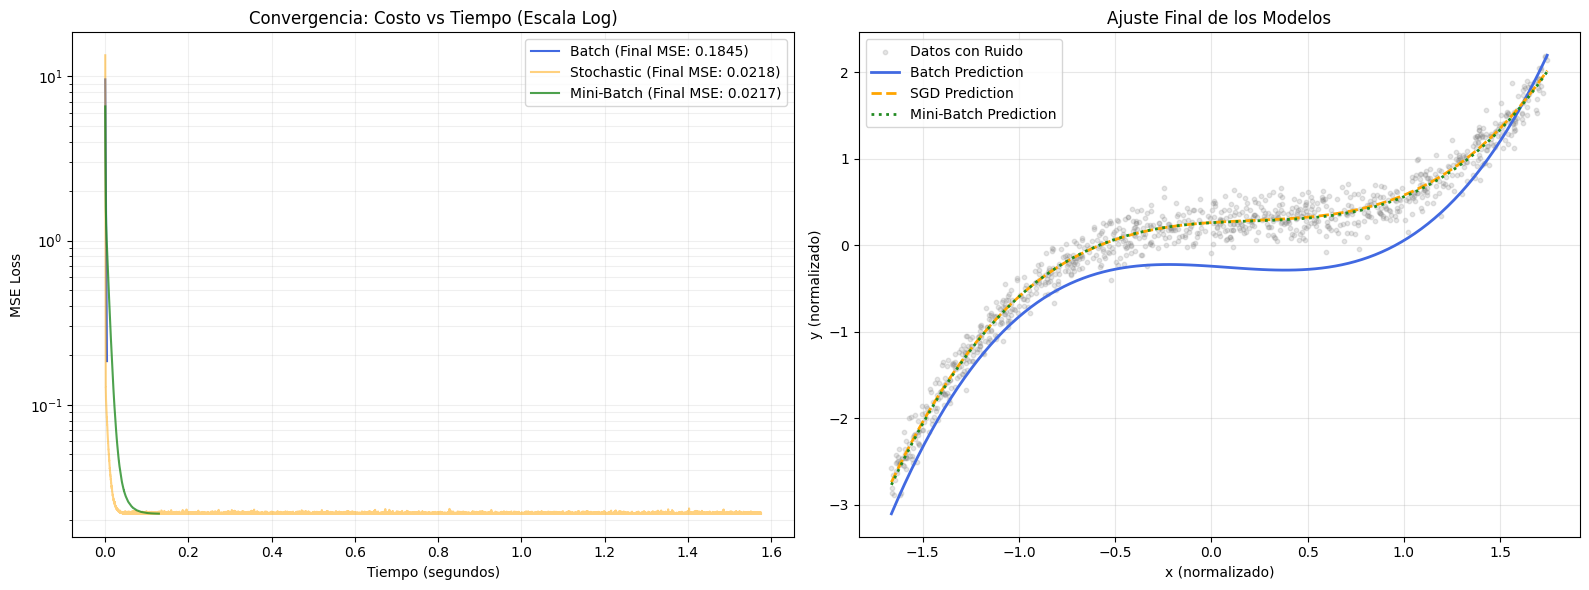

In [88]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(t_batch, l_batch, label=f'Batch (Final MSE: {l_batch[-1]:.4f})', color='royalblue')
plt.plot(t_sgd, l_sgd, label=f'Stochastic (Final MSE: {l_sgd[-1]:.4f})', color='orange', alpha=0.5)
plt.plot(t_mini, l_mini, label=f'Mini-Batch (Final MSE: {l_mini[-1]:.4f})', color='forestgreen', alpha=0.8)

plt.yscale('log')
plt.title("Convergencia: Costo vs Tiempo (Escala Log)")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.subplot(1, 2, 2)
plt.scatter(x_norm, y_norm, color='gray', alpha=0.2, s=10, label='Datos con Ruido')

x_range = np.linspace(x_norm.min(), x_norm.max(), 100).reshape(-1, 1)
X_p = np.c_[np.ones((100, 1)), x_range, x_range**2, x_range**3]

plt.plot(x_range, X_p @ w_batch, label='Batch Prediction', color='royalblue', linewidth=2)
plt.plot(x_range, X_p @ w_sgd, label='SGD Prediction', color='orange', linestyle='--', linewidth=2)
plt.plot(x_range, X_p @ w_mini, label='Mini-Batch Prediction', color='forestgreen', linestyle=':', linewidth=2)

plt.title("Ajuste Final de los Modelos")
plt.xlabel("x (normalizado)")
plt.ylabel("y (normalizado)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### c. Conclusión

Lo primero que podemos observar en la gráfica, es que tenemos comportamientos bastante particulares para cada una de nuestras implementaciones. Me gustaría aclarar que, tomando en cuenta la guía / búsqueda en internet al utilizar SGD cada una de las épocas actualiza N veces los pesos dados N observaciones dentro del dataset. Es decir, al utilizar 500 Epochs realmente no estamos haciendo 500 actualizaciones si no que 500 * N. Adicionalmente, tenemos un costo computacional más alto al realizar shuffling del array por cada Epoch que llevamos a cabo. Esto explica por qué el SGD "alarga" nuestro eje X, indicando que corrió por más tiempo.

Por otro lado, el Batch Gradient Descent utilizando la misma cantidad de épocas técnicamente dejó de entrenarse más rápido. Esto es debido a que no tenemos un shuffle por iteración y que adicionalmente fue implementado utilizando operaciones matriciales para una regresión relativamente simple. Una comparación más justa, en mi opinión, sería utilizar números de Epoch diferentes para cada una de nuestras implementaciones y poder observar la gráfica "completa" de convergencia de BGD. Adicionalmente, tomé en consideración simplemente aumentar el número de épocas pero esto causaba que la gráfica se viera "alargada" aún más por SGD y no fue observable el resultado.

Con esto aclarado, podemos "generalizar" un poco el comportamiento de Mini-Batch como un punto medio entre las demás implementaciones. Ya con la gráfica explicada y detalladas las implementaciones, podemos responder algunas de las preguntas planteadas dentro del laboratorio.

*¿Cuál método converge más rápido al principio?*

El método que converge más rápidamente es SGD, esto se debe a que los pesos de van actualizando por cada datapoint individual. Vale la pena recalcar también, que converge más rápido en cuanto a la gráfica de tiempo pero probablemente no lo haga en cuánto a épocas. También vale la pena mencionar que Mini-Batch también parece haber llegado a converger, sin embargo iba un poco más "atrasado" en comparación a Batch. Esto probablemente se debe a lo anteriormente mencionado, dónde al utilizar implementaciones matriciales para un problema simple el algoritmo de Batch puede iterar rápidamente.

*¿Cuál obtiene el error final más bajo y estable?*

Realmente, entre Mini-Batch y Stochastic se obtuvieron los mejores valores de error. Esto también se puede observar en la gráfica de la derecha, dónde son los dos algoritmos que generaron predicciones precisas. Por otro lado, Batch falló al no tener suficiente "tiempo" (realmente, épocas) para converger de manera adecuada. Para esta problemática en específico, únicamente tomaría en cuenta SGD y Mini-Batch. Para estos dos, SGD obtuvo un descenso bastante rápido pero podemos ver también en la gráfica que tuvo algunas oscilaciones luego de acercarse. Esto probablemente nos indica que en la superficie del error existía un "valle" dónde gracias al Learning Rate y la variabilidad al utilizar un único punto para actualizar pesos no se logró descender al mínimo que se buscaba. Por otro lado, tenemos Mini-Batch que tomó un poco más de tiempo pero el descenso se ve significativamente más estable. Aquí no logramos observar los jitters, por lo que podemos intuir que el algoritmo estaba bajando de manera "suave" hacia un nuevo mínimo.

*Conclusión Final*

Considerando las limitaciones del Laboratorio, se logró explorar un poco sobre las ventajas o desventajas de SGD, BGD y Mini-Batch. Considero que se podrían continuar explorando algunas de estas diferencias utilizando problemas más complejos metodología un poco más completa, comparando tiempos por época y demás. Adicionalmente, queda sin explorar el tema de eficiencia de memoria. Utilizando Batch, todos los datos deben de ser cargados a memoria y esto puede ser una operación sumamente costosa para datasets más grandes. Aquí únicamente contábamos con 1,000 datos, por lo que este problema realmente no se pudo observar.